In [1]:
#coding: utf-8
import numpy as np
import pandas as pd
import re
import jieba
import os
import time
import random
import jieba  #处理中文
import sklearn #分类器
from sklearn.naive_bayes import MultinomialNB  #也可以换成伯努利或高斯的贝叶斯试试看
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import time
import gensim
import jieba.analyse
import time

In [2]:
from gensim.models import CoherenceModel
from gensim import models
def tw_lda_get_tfidf(text,gamma=1.0):
    #1.用正文+标题作为dictionary，过滤极端值
    #--------------下面这里修改
    content_and_title=[i.split(" ") for i in text["微博正文(无标题切词后)"]]
    dictionary = gensim.corpora.Dictionary(content_and_title)
    #-------------下面这里修改
    dictionary.filter_extremes(no_below=15,no_above=0.8, keep_n=100000)
    
    #2.计算标题的tfidf
    #--------------下面这里修改
    processed_docs_title=[i.split(" ") for i in text["标题(切词后)"]]
    bow_corpus_title = [dictionary.doc2bow(doc) for doc in processed_docs_title]
    tfidf_title = models.TfidfModel(bow_corpus_title,normalize=False)
    corpus_tfidf_title = tfidf_title[bow_corpus_title]
#     print("corpus_tfidf_title",corpus_tfidf_title)
    
    #3.计算正文+标题的tfidf
    #--------------下面这里修改
    processed_docs_content=[i.split(" ") for i in text["微博正文(无标题切词后)"]]
    bow_corpus_content = [dictionary.doc2bow(doc) for doc in processed_docs_content]
    tfidf_content = models.TfidfModel(bow_corpus_content,normalize=False)
    corpus_tfidf_content = tfidf_content[bow_corpus_content]
#     print("corpus_tfidf_content",corpus_tfidf_content)
    
    #4.把标题和正文tfidf结合在一起
    new_tfidf=[]
    for i in range(len(corpus_tfidf_content)):#corpus_tfidf2[i]
        dict_2={one:two for one,two in corpus_tfidf_content[i]}
        dict_1={one:two for one,two in corpus_tfidf_title[i]}
        for j in dict_1.keys():
            if j in dict_2.keys():
                dict_2[j]=(1-gamma)*dict_2[j]+gamma*dict_1[j]
        new_tfidf_part=[(one,two) for one,two in sorted(dict_2.items(), key=lambda d: d[0],reverse=False)]
#         print("new_tfidf_part",new_tfidf_part)
#        new_tfidf.append(new_tfidf_part)
#        normed=gensim.models.tfidfmodel.smartirs_normalize(new_tfidf_part,"c")  #-------------这里改了把这个取消归一化了
#        new_tfidf.append(normed)
        new_tfidf.append(new_tfidf_part)
    
    #5.返回tfidf
    return new_tfidf,dictionary


# lda的模型
from gensim.models import CoherenceModel
from gensim import models

def lda_and_coherence_score(processed_docs,num_topics,methods,corpus_tfidf_tw_lda=False,dictionary_tw_lda=False):
    
    if methods=="tw_lda":
        dictionary=dictionary_tw_lda
        corpus=corpus_tfidf_tw_lda
    else:
        dictionary = gensim.corpora.Dictionary(processed_docs)
        dictionary.filter_extremes(no_below=15, no_above=0.8, keep_n=100000)
        bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
        if methods=="lda_normal":
            corpus=bow_corpus
        elif methods=="lda_tfidf":
            tfidf = models.TfidfModel(bow_corpus,normalize=False)#-----------------这里改了，改成false
            corpus_tfidf = tfidf[bow_corpus]
            corpus=corpus_tfidf
    model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary,
                                       passes=20,iterations=5000
                                       #,eval_every=1
                                      )
    coherence = CoherenceModel(model=model, texts=processed_docs,dictionary=dictionary, coherence='c_v')
    score = coherence.get_coherence()
    logper=model.log_perplexity(corpus)
    return model,score,logper


#----------增加一步，算5次平均【def名中的10没改，但实际是算5次】
def cs_bar_10(c,num_topics,methods,corpus_tfidf_tw_lda=False,dictionary_tw_lda=False):
    cs_list=[]
    logper_list=[]
    if methods=="tw_lda":
        for i in range(5):
            lda,cs,logper=lda_and_coherence_score(c,num_topics,methods,corpus_tfidf_tw_lda=corpus_tfidf_tw_lda,dictionary_tw_lda=dictionary_tw_lda)
            cs_list.append(cs)
            logper_list.append(logper)
    else:
        for i in range(5):
            lda,cs,logper=lda_and_coherence_score(c,num_topics,methods)
            cs_list.append(cs)
            logper_list.append(logper)
#     cs_bar_10=sum(cs_list)/(len(cs_list)*1.0)               #----------------这里也改了
#     logper_bar_10=sum(logper_list)/(len(logper_list)*1.0)   #----------------这里也改了
    return lda,cs_list,logper_list                            #----------------这里也改了

In [3]:
text=pd.read_csv("./huanqiu_news_with_title_2.csv")
#看text里有没有空值的项，因为split会发错误
drop_na=[]
for i in range(text.shape[0]):
    if pd.isnull(text.loc[i]).any():
        drop_na.append(i)

text=text.drop(drop_na)
text=text.reset_index(drop=True)

text.head()

,发布时间,微博正文,标题,微博正文（去掉标题）,微博正文(无标题切词后),标题(切词后),微博正文(有标题切词后)
0,2019-12-31 23:50,【如何获得稳定的8小时睡眠？】如今随着新的信息技术的发展，比如笔记本电脑，手机，游戏成了影响...,【如何获得稳定的8小时睡眠？】,如今随着新的信息技术的发展，比如笔记本电脑，手机，游戏成了影响着人们的睡眠时间的主要原因，7...,获得 稳定 小时 睡眠 信息技术 发展 笔记本电脑 手机 游戏 影响 人们 睡眠 主要 原因...,获得 稳定 小时 睡眠,获得 稳定 小时 睡眠 获得 稳定 小时 睡眠 信息技术 发展 笔记本电脑 手机 游戏 影响...
1,2019-12-31 23:30,【这妈妈不太省心！怕被抓拍#女子拿孩子的画遮号牌#】近日，四川自贡市一女子违停在路边，由于担...,【这妈妈不太省心！怕被抓拍#女子拿孩子的画遮号牌#】,近日，四川自贡市一女子违停在路边，由于担心被监控抓拍，竟用孩子的画遮挡号牌。孩子制止其母无果...,妈妈 不太 省心 抓拍 孩子 号牌 自贡市 违停 路边 担心 监控 抓拍 孩子 遮挡 号牌 ...,妈妈 省心 抓拍 孩子 号牌,妈妈 省心 抓拍 孩子 号牌 妈妈 不太 省心 抓拍 孩子 号牌 自贡市 违停 路边 担心 ...
2,2019-12-31 23:10,【#致敬2019那些温暖瞬间#，愿2020更美好】回顾2019年，发生在齐鲁大地上，值得记忆...,【#致敬2019那些温暖瞬间#，愿2020更美好】,回顾2019年，发生在齐鲁大地上，值得记忆的暖心瞬间：10岁男孩2月增重12斤捐造干救父；夫...,致敬 温暖 瞬间 美好 回顾 齐鲁大地 值得 记忆 瞬间 男孩 增重 捐造 干救父 夫妻 雾...,致敬 温暖 瞬间 美好,致敬 温暖 瞬间 美好 致敬 温暖 瞬间 美好 回顾 齐鲁大地 值得 记忆 瞬间 男孩 增重...
3,2019-12-31 22:50,【浪漫！#85岁爷爷敬老院娶82岁奶奶#：上海话“搭讪”，开音乐会庆祝】 陕西西安一敬老院，...,【浪漫！#85岁爷爷敬老院娶82岁奶奶#：上海话“搭讪”，开音乐会庆祝】,陕西西安一敬老院，85岁的陈爷爷迎娶82岁的沈奶奶。沈奶奶爱在大厅里弹钢琴，陈爷爷常坐在后...,浪漫 爷爷 敬老院 奶奶 上海 搭讪 音乐会 庆祝 陕西 西安 敬老院 爷爷 迎娶 奶奶 奶...,浪漫 爷爷 敬老 敬老院 奶奶 上海 搭讪 音乐 音乐会 会庆 庆祝,浪漫 爷爷 敬老 敬老院 奶奶 上海 搭讪 音乐 音乐会 会庆 庆祝 浪漫 爷爷 敬老院 奶...
4,2019-12-31 22:30,【瑞典环保少女：不想和特朗普说话，不想浪费时间】12月30日，瑞典环保少女通贝里接受BBC《...,【瑞典环保少女：不想和特朗普说话，不想浪费时间】,12月30日，瑞典环保少女通贝里接受BBC《今日》电台采访时，被问到如果有机会跟特朗普面对面...,瑞典 环保 少女 不想 特朗普 说话 不想 浪费时间 瑞典 环保 少女 贝里 接受 今日 电...,瑞典 环保 少女 不想 特朗普 说话 不想 浪费 浪费时间 费时 费时间,瑞典 环保 少女 不想 特朗普 说话 不想 浪费 浪费时间 费时 费时间 瑞典 环保 少女 ...


In [1]:
c=[i.split(" ") for i in text["微博正文(有标题切词后)"]]

NameError: name 'text' is not defined

In [5]:
tn=50 #把确定好的主题数放进这里（和上一小节中的一致）
ga=0.5#把确定好的gamma放进这里

a,b=tw_lda_get_tfidf(text,gamma=ga)
lda3,cs3,logper3=cs_bar_10(c,
                           tn,
                           "tw_lda",
                           corpus_tfidf_tw_lda=a,
                           dictionary_tw_lda=b)
text_topics3=lda3.get_document_topics(a)

TW-LDA可视化

In [ ]:
import pyLDAvis
import pyLDAvis.gensim


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda3, a, b)

end_lda = time.clock()

#pyLDAvis.show(vis)

In [ ]:
pyLDAvis.show(vis)

分主题看微博量

In [ ]:
lda3.print_topics(-1,20)

In [6]:
text_topics_dict3={}
for i in range(tn):
    text_topics_dict3[i]=[]
    
text_topics_no_dict3={}
for i in range(tn):
    text_topics_no_dict3[i]=[]

for i in range(len(text_topics3)):
    dict_text_topics3=dict(text_topics3[i])
    #print(dict_text_topics3)
    for key,value in dict_text_topics3.items():
        if(value == max(dict_text_topics3.values()) and str(max(dict_text_topics3.values()))!="0.02"):
            text_topics_dict3[key].append(value)
            text_topics_no_dict3[key].append(i)

In [7]:
lda3.print_topics(-1,20)

[(0,
  '0.023*"研究" + 0.014*"容易" + 0.012*"手机" + 0.012*"老板" + 0.010*"年轻人" + 0.010*"粉丝" + 0.009*"风险" + 0.009*"减肥" + 0.009*"帮助" + 0.009*"朋友" + 0.009*"转给" + 0.009*"食品" + 0.009*"魔王" + 0.008*"全球" + 0.008*"食物" + 0.007*"答案" + 0.007*"表明" + 0.007*"快乐" + 0.006*"功能" + 0.006*"偷走"'),
 (1,
  '0.053*"游客" + 0.026*"旅游" + 0.024*"朝鲜" + 0.020*"领导人" + 0.020*"景区" + 0.019*"金正恩" + 0.018*"公园" + 0.014*"拍照" + 0.013*"峰会" + 0.011*"国家" + 0.011*"邀请" + 0.010*"假期" + 0.009*"会面" + 0.009*"狮子" + 0.008*"主席" + 0.008*"参选" + 0.008*"中国" + 0.008*"参观" + 0.008*"授予" + 0.006*"大象"'),
 (2,
  '0.034*"华为" + 0.024*"德国" + 0.014*"故事" + 0.014*"中国" + 0.014*"美国" + 0.012*"亿元" + 0.011*"增长" + 0.010*"讲述" + 0.010*"任正非" + 0.010*"下降" + 0.009*"欧洲" + 0.009*"西方" + 0.009*"专访" + 0.008*"采访" + 0.008*"内心" + 0.007*"运营商" + 0.007*"接受" + 0.007*"芯片" + 0.007*"出售" + 0.007*"多位"'),
 (3,
  '0.055*"印度" + 0.030*"伊朗" + 0.025*"巴基斯坦" + 0.017*"美军" + 0.015*"空军" + 0.015*"无人机" + 0.014*"军方" + 0.014*"留学生" + 0.013*"攻击" + 0.012*"击落" + 0.012*"战机" + 0.012*"美国" + 0.011*"目标" + 0.009*"

In [ ]:
lda3.show_topic(1,    #改变这个看不同主题,总结规律
                      #（和上一小节好像差不多，看看是不是）
                20)   #20个关键词

[('香港', 0.019728458), ('郑月', 0.019424945), ('特区政府', 0.013755426), ('土耳其', 0.013065759), ('恢复', 0.012538989), ('行政长官', 0.011413538), ('社会', 0.010737011), ('过度', 0.009980948), ('谴责', 0.009454531), ('墨西哥', 0.009227845), ('暴力', 0.009208748), ('香港特区政府', 0.009134896), ('止暴', 0.0091195665), ('法治', 0.008574959), ('秩序', 0.008475518), ('挑战', 0.008416649), ('制乱', 0.008304863), ('警队', 0.007615074), ('底线', 0.007300119), ('伤害', 0.006797924)]
{'01': 8, '02': 7, '03': 6, '04': 7, '05': 8, '06': 5, '07': 32, '08': 134, '09': 56, '10': 45, '11': 138, '12': 34}


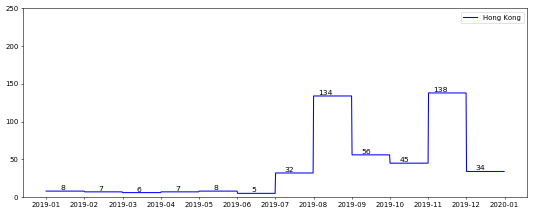

In [24]:
#编号为1的主题
topic_id=1
print(lda3.show_topic(1,20))
import re
time_3={}
for i in range(1,13):
    month_text=0
    if len(str(i))==1:
        mon="0"+str(i)
    else:
        mon=str(i)
    month_re='2019-'+mon
    time_list=text["发布时间"][text_topics_no_dict3[topic_id]]
    for j in time_list:
        if month_re in j:
            month_text=month_text+1
    time_3[mon]=month_text
print(time_3)

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

plt.figure(figsize=(13,5),dpi=50)

month_re_list=[]
for i in range(1,13):
    if len(str(i))==1:
        mon="0"+str(i)
    else:
        mon=str(i)
    month_re='2019-'+mon
    month_re_list.append(month_re)
month_re_list.append('2020-01')
#print("month_re_list",month_re_list)
new_ticks =month_re_list

plt.xticks(range(1,14),new_ticks)

plt.ylim(0, 250)

x = [int(i[0]) for i in time_3.items()]
x.append(13)

y = [int(i[1]) for i in time_3.items()]
y.append(0)
#np.linspace(0, 10, num=11, endpoint=True)

f2 = interp1d(x, y, kind='zero')

xnew = np.linspace(1, 13, num=1001, endpoint=False)
#plt.plot(x, y, 'o')
plt.plot(xnew, f2(xnew), '-',color='blue')
plt.legend(['Topic1', 'zero'], loc='best')

x1=[int(i[0]) for i in time_3.items()]
y1=[int(i[1]) for i in time_3.items()]

for m,n in zip(x1,y1):
    plt.text(m+0.5, n+0.15, '%.0f' % n, ha='right', va= 'bottom',fontsize=11)

plt.show()
